# Fluidity Local: Stress Relaxation with Thixotropic Aging

**Learning Objectives:**
- Fit FluidityLocal to stress relaxation data from thixotropic yield-stress fluids
- Understand non-exponential relaxation driven by evolving fluidity f(t)
- Track accelerating relaxation from structural recovery (aging: f → f_eq)
- Compare FluidityLocal vs Maxwell-type exponential decay

**Prerequisites:** basic/01, bayesian/01, fluidity/01 (flow curve)

**Runtime:** Fast ~2 min (num_chains=1), Full ~5 min (num_chains=4)

## 1. Setup

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os

    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
import os
import sys

%matplotlib inline
import json
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
sys.path.insert(0, os.path.join("..", "utils"))
from fluidity_tutorial_utils import (
    generate_synthetic_relaxation,
    get_output_dir,
    print_convergence_summary,
    print_parameter_comparison,
    save_fluidity_results,
)
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fluidity import FluidityLocal

jax, jnp = safe_import_jax()
verify_float64()

# Suppress upstream equinox DeprecationWarning (jax.core.mapped_aval deprecated)
warnings.filterwarnings(
    "ignore",
    message="jax.core.*_aval is deprecated",
    category=DeprecationWarning,
    module="equinox",
)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

# Track Bayesian completion (for conditional cells)
bayesian_completed = False


JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## 2. Theory: Fluidity Stress Relaxation

After a step strain γ₀ is imposed at t=0, the stress relaxes as:

$$\frac{d\sigma}{dt} = -G\sigma f(t), \quad \frac{df}{dt} = \frac{f_{eq} - f}{\theta}$$

where:
- **G**: Elastic modulus (Pa)
- **f(t)**: Time-dependent fluidity (1/(Pa·s))
- **f_eq**: Equilibrium fluidity at rest (1/(Pa·s))
- **θ**: Aging time scale (s)

**Key Behavior:**
1. **Initial fast decay**: f starts high (from prior flow), σ decays rapidly
2. **Aging slowdown**: f decreases toward f_eq as structure recovers
3. **Accelerating relaxation**: Lower f means slower stress relaxation → stretched exponential signature

**Contrast with Maxwell:** Standard viscoelastic models predict σ(t) = σ₀ exp(-t/τ) with constant relaxation time τ. Fluidity models exhibit **time-dependent relaxation** due to evolving microstructure.

**Thixotropic Signature:** The relaxation modulus G(t) = σ(t)/γ₀ decays faster at short times (high f, recent flow) and slower at long times (low f, structural recovery).

## 3. Load Data

We'll use synthetic data generated from a calibrated FluidityLocal model. In practice, you would load experimental relaxation data from laponite clays or other thixotropic materials.

In [4]:
# Generate synthetic relaxation data
# (In real workflow, load from clay data: load_clay_relaxation(aging_time=60))

# Create a reference model with thixotropic parameters
model_ref = FluidityLocal()
model_ref.parameters.set_value("G", 1000.0)  # Pa
model_ref.parameters.set_value("tau_y", 50.0)  # Pa
model_ref.parameters.set_value("K", 10.0)  # Pa·s^n
model_ref.parameters.set_value("n_flow", 0.5)  # dimensionless
model_ref.parameters.set_value("f_eq", 0.001)  # 1/(Pa·s)
model_ref.parameters.set_value("f_inf", 0.01)  # 1/(Pa·s)
model_ref.parameters.set_value("theta", 10.0)  # s
model_ref.parameters.set_value("a", 0.1)  # dimensionless
model_ref.parameters.set_value("n_rejuv", 1.0)  # dimensionless
model_ref.fitted_ = True

# Generate synthetic data
t_data, stress = generate_synthetic_relaxation(
    model_ref, sigma_0=500.0, t_end=100.0, n_points=80, noise_level=0.05, seed=42
)

print(f"Data: {len(t_data)} points, t=[{t_data.min():.3f}, {t_data.max():.1f}] s")
print(f"Stress range: [{stress.min():.1f}, {stress.max():.1f}] Pa")

Data: 80 points, t=[0.010, 100.0] s
Stress range: [-9.4, 501.7] Pa


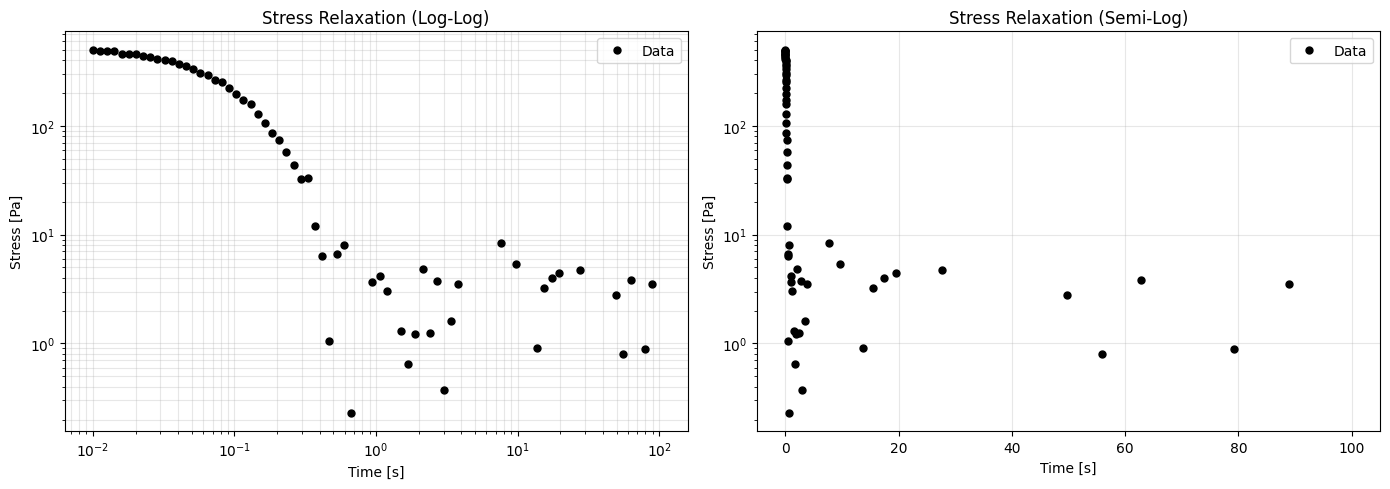

In [5]:
# Visualize relaxation data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Log-log plot
ax1.loglog(t_data, stress, "ko", markersize=5, label="Data")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Stress Relaxation (Log-Log)")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Semi-log plot (to show deviation from exponential)
ax2.semilogy(t_data, stress, "ko", markersize=5, label="Data")
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress [Pa]")
ax2.set_title("Stress Relaxation (Semi-Log)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## 4. NLSQ Fitting

### 4.1 Fit FluidityLocal to Relaxation Data

In [6]:
model = FluidityLocal()

t0_fit = time.perf_counter()
model.fit(t_data, stress, test_mode="relaxation", sigma_0=stress[0], method='scipy')

# Compute fit quality
stress_pred_data = model.predict(t_data, test_mode="relaxation", sigma_0=stress[0])
metrics = compute_fit_quality(stress, stress_pred_data)
t_nlsq = time.perf_counter() - t0_fit

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa")
print("\nFitted parameters:")
param_names = ["G", "tau_y", "K", "n_flow", "f_eq", "f_inf", "theta", "a", "n_rejuv"]
for name in param_names:
    val = model.parameters.get_value(name)
    print(f"  {name:10s} = {val:.4g}")

NLSQ fit time: 26.52 s
R²: 0.712016
RMSE: 91.66 Pa

Fitted parameters:
  G          = 1.878e+05
  tau_y      = 831.4
  K          = 738.8
  n_flow     = 1.935
  f_eq       = 2.998e-08
  f_inf      = 0.0001891
  theta      = 0.2627
  a          = 1
  n_rejuv    = 1


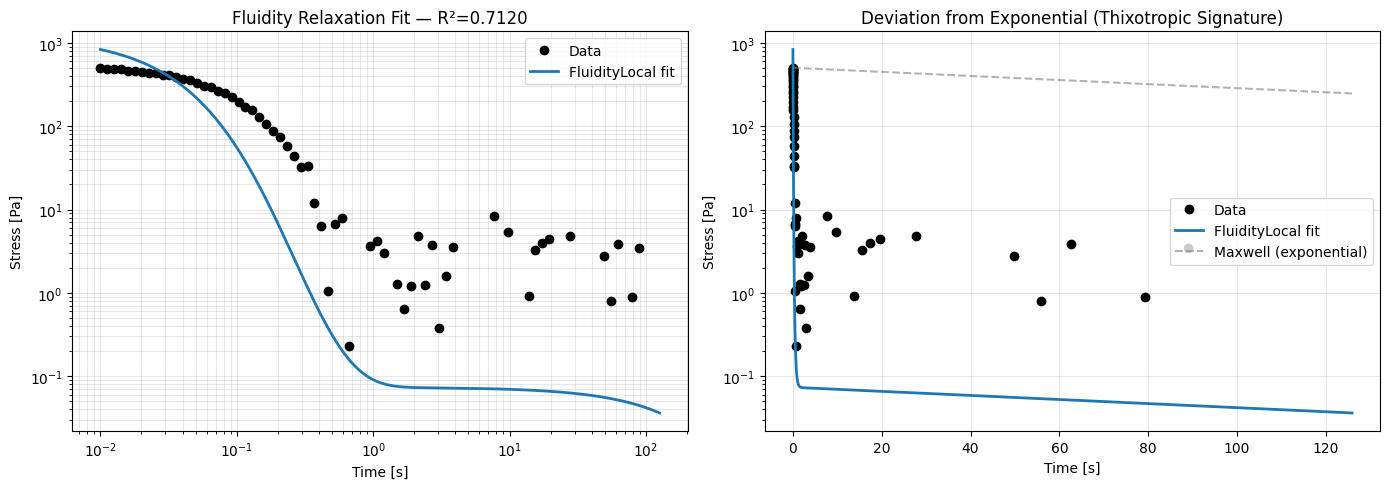

In [7]:
# Predict and compare
# t_fine must start at or after t_data.min() for ODE integration to work
t_fine = np.logspace(np.log10(t_data.min()), np.log10(t_data.max()) + 0.1, 200)
stress_pred = model.predict(t_fine, test_mode="relaxation", sigma_0=stress[0])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Log-log
ax1.loglog(t_data, stress, "ko", markersize=6, label="Data")
ax1.loglog(t_fine, stress_pred, "-", lw=2, color="C0", label="FluidityLocal fit")
ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title(f"Fluidity Relaxation Fit — R²={metrics['R2']:.4f}")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Semi-log (curvature = non-exponential)
ax2.semilogy(t_data, stress, "ko", markersize=6, label="Data")
ax2.semilogy(t_fine, stress_pred, "-", lw=2, color="C0", label="FluidityLocal fit")

# Reference exponential for comparison (Maxwell with tau = 1/(G*f_eq))
G_fit = model.parameters.get_value("G")
f_eq_fit = model.parameters.get_value("f_eq")
tau_maxwell = 1.0 / (G_fit * f_eq_fit + 1e-30)
stress_maxwell = stress[0] * np.exp(-t_fine / tau_maxwell)
ax2.semilogy(
    t_fine, stress_maxwell, "--", lw=1.5, color="gray", alpha=0.6, label="Maxwell (exponential)"
)

ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Stress [Pa]")
ax2.set_title("Deviation from Exponential (Thixotropic Signature)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

### 4.2 Fluidity Evolution During Relaxation

To visualize the thixotropic aging mechanism, we simulate the fluidity evolution f(t) during relaxation.

In [8]:
# Simulate fluidity evolution using diffrax
import diffrax

from rheojax.models.fluidity._kernels import fluidity_local_ode_rhs

# Get fitted parameters
p = model.get_parameter_dict()
f_init = p["f_inf"]  # Start with high fluidity (just flowed)
sigma_init = stress[0]

# ODE arguments
args = {
    "G": p["G"],
    "f_eq": p["f_eq"],
    "f_inf": p["f_inf"],
    "theta": p["theta"],
    "a": p["a"],
    "n_rejuv": p["n_rejuv"],
    "gamma_dot": 0.0,  # No flow during relaxation
}

# Initial state: [sigma, f]
y0 = jnp.array([sigma_init, f_init])

# Time span - use t_data bounds to ensure saveat is within bounds
t_span = jnp.array([t_data.min(), t_data.max()])

# t_fine must be within [t_span[0], t_span[1]] for diffrax saveat
t_fine_ode = np.linspace(float(t_data.min()), float(t_data.max()), 200)
saveat = diffrax.SaveAt(ts=jnp.asarray(t_fine_ode))

# Solve ODE
term = diffrax.ODETerm(fluidity_local_ode_rhs)
solver = diffrax.Tsit5()
stepsize_controller = diffrax.PIDController(rtol=1e-6, atol=1e-8)

sol = diffrax.diffeqsolve(
    term,
    solver,
    t0=t_span[0],
    t1=t_span[1],
    dt0=0.01,
    y0=y0,
    args=args,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=1_000_000,
)

stress_sim = np.array(sol.ys[:, 0])
fluidity_sim = np.array(sol.ys[:, 1])

print(f"Fluidity range: [{fluidity_sim.min():.4g}, {fluidity_sim.max():.4g}] 1/(Pa·s)")
print(f"f_eq (target): {p['f_eq']:.4g} 1/(Pa·s)")

Fluidity range: [2.992e-08, 0.0001891] 1/(Pa·s)
f_eq (target): 2.998e-08 1/(Pa·s)


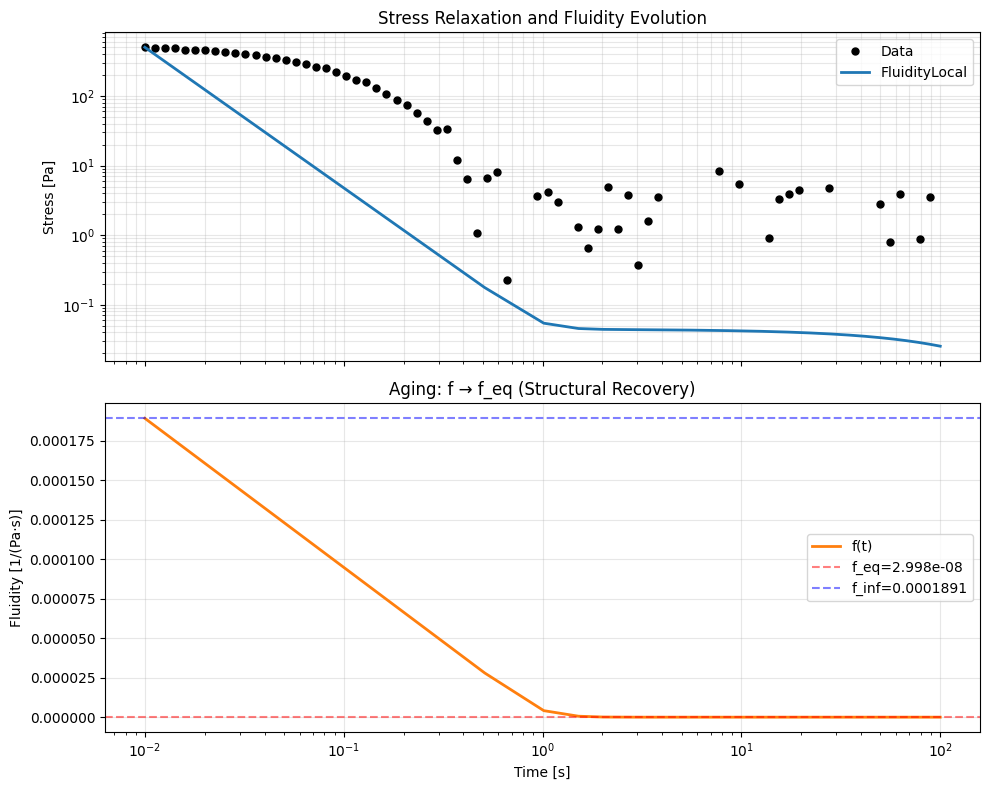

In [9]:
# Plot stress and fluidity evolution
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Stress
ax1.loglog(t_data, stress, "ko", markersize=5, label="Data")
ax1.loglog(t_fine_ode, stress_sim, "-", lw=2, color="C0", label="FluidityLocal")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Stress Relaxation and Fluidity Evolution")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Fluidity
ax2.semilogx(t_fine_ode, fluidity_sim, "-", lw=2, color="C1", label="f(t)")
ax2.axhline(
    p["f_eq"], color="red", linestyle="--", alpha=0.5, lw=1.5, label=f"f_eq={p['f_eq']:.4g}"
)
ax2.axhline(
    p["f_inf"], color="blue", linestyle="--", alpha=0.5, lw=1.5, label=f"f_inf={p['f_inf']:.4g}"
)
ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Fluidity [1/(Pa·s)]")
ax2.set_title("Aging: f → f_eq (Structural Recovery)")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

**Interpretation:**
- **Upper panel:** Stress decays non-exponentially (curved on semi-log plot)
- **Lower panel:** Fluidity f(t) decreases from f_inf (high, recent flow) toward f_eq (low, structural recovery)
- **Mechanism:** Lower f → slower stress relaxation → accelerating decay signature

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

In [10]:

# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference')
    bayesian_completed = False
else:
    initial_values = {name: model.parameters.get_value(name) for name in param_names}
    print("Warm-start values:")
    for name, val in initial_values.items():
        print(f"  {name:10s} = {val:.4g}")

    # FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
    FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
    if FAST_MODE:
        NUM_WARMUP = 50
        NUM_SAMPLES = 100
        NUM_CHAINS = 1
    else:
        NUM_WARMUP = 200
        NUM_SAMPLES = 500
        NUM_CHAINS = 1

    t0 = time.perf_counter()
    result = model.fit_bayesian(
        t_data,
        stress,
        test_mode="relaxation",
        sigma_0=stress[0],
        num_warmup=NUM_WARMUP,
        num_samples=NUM_SAMPLES,
        num_chains=NUM_CHAINS,
        initial_values=initial_values,
        seed=42,
    )
    t_bayes = time.perf_counter() - t0
    print(f"\nBayesian inference time: {t_bayes:.1f} s")

    bayesian_completed = True



FAST_MODE: Skipping Bayesian inference


### 5.2 Convergence Diagnostics

In [11]:
if bayesian_completed:
    converged = print_convergence_summary(result, param_names=param_names)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


### 5.3 ArviZ Diagnostic Plots

In [12]:
if bayesian_completed:
    display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


### 5.4 Posterior Predictive Check

In [13]:
if bayesian_completed:
    fig, ax = plot_posterior_predictive(
        t_data, stress, model, result,
        test_mode="relaxation",
        param_names=param_names,
        log_scale=True,
        xlabel="Time [s]",
        ylabel="Stress [Pa]",
        title="Posterior Predictive Check", sigma_0=stress[0],
    )
    plt.close("all")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


### 5.5 Parameter Comparison

In [14]:
if bayesian_completed:
    print_parameter_comparison(model, posterior, param_names=param_names)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


## 6. Save Results

In [15]:
if bayesian_completed:
    save_fluidity_results(
        model, result, model_variant="local", protocol="relaxation", param_names=param_names
    )

    # Also save fluidity evolution for future reference
    output_dir = get_output_dir("local", "relaxation")
    fluidity_data = {"time": t_fine.tolist(), "fluidity": fluidity_sim.tolist()}
    with open(os.path.join(output_dir, "fluidity_evolution.json"), "w") as f:
        json.dump(fluidity_data, f)
    print(f"Fluidity evolution saved to {output_dir}/fluidity_evolution.json")
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')


Skipping (Bayesian inference was skipped in FAST_MODE)


## Key Takeaways

1. **Non-exponential decay**: FluidityLocal predicts σ(t) decay faster than simple exponential due to time-varying fluidity f(t), reflecting thixotropic aging.

2. **Aging mechanism**: After flow stops (γ̇=0), fluidity f(t) decreases from f_inf (high, recent flow) toward f_eq (low, structural recovery). This is the structural aging signature.

3. **Accelerating relaxation**: Lower f → slower stress relaxation rate dσ/dt = -Gσf. The relaxation time τ_eff(t) = 1/(Gf(t)) increases with time, creating stretched exponential behavior.

4. **Contrast with Maxwell**: Standard viscoelastic models show straight lines on semi-log plots (exponential). Fluidity models show curvature due to evolving microstructure.

5. **Parameter identifiability**: Relaxation data primarily constrains G, f_eq, and θ (aging time). Flow parameters (tau_y, K, n) have weak influence but are needed for full model consistency.

**Next Steps:** Explore startup shear (NB 02) for stress overshoot from thixotropic breakdown, or creep (NB 03) for delayed yielding. Both protocols reveal complementary aspects of fluidity dynamics.